In [22]:
import os
raw_data_dir = ''
acc_key = 'acc'
plot_examples = False # notebook file size will increase by 30 to 60MB if set to True; <1MB otherwise

if  'COLAB_GPU' in os.environ :
    print('Using Google Colab. Setting up environment')
    raw_data_dir = '/content/drive/My Drive/Colab Notebooks/' 
    !pip install mne
    !pip install pyedflib
    print('\n \n To load files from Google Drive, account validation is required.')
    # mount to drive -- files should be located in the /Colab Notebooks directory
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils

elif 'KAGGLE_URL_BASE' in os.environ:
    acc_key = 'accuracy'
    print('Using Kaggle kernel. Setting up environment')
    !pip install pyedflib
    !pip install chart_studio
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/Data/Raw
    raw_data_dir = 'Raw/'
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils Utils


else:
    # assuming that a local run will be launched only from a github project; 
    # add the utils and ReadData directories to the temporary path
    if 'HOMEPATH' in os.environ:
        print('Using homepath ' + os.environ['HOMEPATH'])
    raw_data_dir = '../../Data/Raw/'
    
    from pathlib import Path
    import sys
    sys.path.append(os.path.realpath('..'))
    path = Path(os.getcwd())
    sys.path.append(str(path.parent.parent))


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

import pandas as pd
import numpy as np
import random 

from importlib import reload  #reload(chart_builder)


#################
# import project utilities and the raw data reader
# Kaggle environment does not accept 'utils' as a file, so it must be accessed seperately

import ReadData.RawDataReader as data_reader
if 'KAGGLE_URL_BASE' in os.environ:
    import Utils.ModelBuilder as model_builder
    import Utils.ChartBuilder as chart_builder
else:
    import utils.ModelBuilder as model_builder
    import utils.ChartBuilder as chart_builder


Using homepath \Users\marit


In [34]:
ignore_list = ['s12', 's14']  # List of patient files that should be skipped
resolution_hz = 250 # Hz resolution - number of frames per second; 250Hz is the selected value for the EEG dataset
time_window = resolution_hz * 20 # Seconds of data to include in one slice;

all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
excluded_channels = [ 'T3', 'T5', 'T6', 'O1', 'F3', 'Fp1', 'Fp2', 'P4']#F8'

chans = len(all_channels) - len(excluded_channels)
data = data_reader.get_raw_data(raw_data_dir, resolution_hz, ignore_list, 
                                excluded_channels, time_window)
#np.save('data', data)

In [25]:
if plot_examples:
    random_selection =  data_reader.get_random_participants(raw_data_dir, data, ignore_list, resolution_hz)
    chart_builder.plot_random_participants(data, ignore_list, excluded_channels, all_channels, random_selection)


In [3]:
def LSTM(time_steps, nb_features, chans, nb_classes):

    model=tf.keras.Sequential()
    
    print('chans: ', chans)
    print('nb_features: ', nb_features)

    units = 90
    dropout_rate = 0.002 * units if units < 100 else 0.15

    #model.add(Bidirectional(layers.LSTM(units,
    #                             dropout = dropout_rate),
    #                                                         input_shape=( time_steps, chans)
    #))

    model.add(layers.LSTM(units,
                          input_shape=( time_steps, chans),
                          dropout = dropout_rate,
                         # return_sequences=True
            ))
    #model.add(Bidirectional(layers.LSTM(math.floor(units/2),
    #                             dropout = dropout_rate/2)))
    #
    model.add(Dense(4,kernel_initializer='he_uniform',activation='relu'))
    

    model.add(Dense(nb_classes,activation='softmax'))
    
    return model

In [35]:
####LSTM

#declare model, optimizer and checkpoint file
model = LSTM(time_steps=time_window, chans=chans, nb_features=1, nb_classes=2 )

opt_adam = tf.keras.optimizers.Adam(lr=0.00004, 
                                beta_1=0.99,
                                beta_2=0.999,
                                epsilon=1e-07)
sgd = tf.keras.optimizers.SGD(lr=0.01)

lstm_checkpoint = '/tmp/LSTM_checkpoint.h5'

fitted_model_lstm = model_builder.construct_and_run_model(data, model, opt_adam, lstm_checkpoint, epochs=200, batch_size=32)


chans:  11
nb_features:  1
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 90)                36720     
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 364       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 10        
Total params: 37,094
Trainable params: 37,094
Non-trainable params: 0
_________________________________________________________________
Train on 450 samples, validate on 100 samples
Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.69358, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 5s - loss: 0.6938 - accuracy: 0.5244 - rmse: 0.4984 - val_loss: 0.6936 - val_accuracy: 0.4800 - val_rmse: 0.5024
Epoch 2/200

Epoch 00002: val_loss improved from 0.69358 to 0.69305, saving mod

Epoch 33/200

Epoch 00033: val_loss improved from 0.67617 to 0.67536, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6766 - accuracy: 0.5822 - rmse: 0.4879 - val_loss: 0.6754 - val_accuracy: 0.6200 - val_rmse: 0.4959
Epoch 34/200

Epoch 00034: val_loss improved from 0.67536 to 0.67454, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6714 - accuracy: 0.6044 - rmse: 0.4905 - val_loss: 0.6745 - val_accuracy: 0.6100 - val_rmse: 0.4957
Epoch 35/200

Epoch 00035: val_loss improved from 0.67454 to 0.67377, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6746 - accuracy: 0.5733 - rmse: 0.4909 - val_loss: 0.6738 - val_accuracy: 0.6200 - val_rmse: 0.4955
Epoch 36/200

Epoch 00036: val_loss improved from 0.67377 to 0.67301, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6723 - accuracy: 0.6022 - rmse: 0.4876 - val_loss: 0.6730 - val_accuracy: 0.6200 - val_rmse: 0.4954
Epoch 37/200

Epoch 00037: val_loss improved from 0.67301 to 0.67220

Epoch 69/200

Epoch 00069: val_loss improved from 0.63212 to 0.62962, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6422 - accuracy: 0.6533 - rmse: 0.4737 - val_loss: 0.6296 - val_accuracy: 0.7000 - val_rmse: 0.4824
Epoch 70/200

Epoch 00070: val_loss improved from 0.62962 to 0.62686, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6460 - accuracy: 0.6333 - rmse: 0.4669 - val_loss: 0.6269 - val_accuracy: 0.7000 - val_rmse: 0.4816
Epoch 71/200

Epoch 00071: val_loss improved from 0.62686 to 0.62360, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6399 - accuracy: 0.6444 - rmse: 0.4711 - val_loss: 0.6236 - val_accuracy: 0.7000 - val_rmse: 0.4805
Epoch 72/200

Epoch 00072: val_loss improved from 0.62360 to 0.61986, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6368 - accuracy: 0.6400 - rmse: 0.4648 - val_loss: 0.6199 - val_accuracy: 0.7000 - val_rmse: 0.4793
Epoch 73/200

Epoch 00073: val_loss improved from 0.61986 to 0.61553

Epoch 105/200

Epoch 00105: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5359 - accuracy: 0.7022 - rmse: 0.4347 - val_loss: 0.4814 - val_accuracy: 0.7300 - val_rmse: 0.4049
Epoch 106/200

Epoch 00106: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5398 - accuracy: 0.6844 - rmse: 0.4366 - val_loss: 0.4816 - val_accuracy: 0.7300 - val_rmse: 0.4047
Epoch 107/200

Epoch 00107: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5385 - accuracy: 0.6956 - rmse: 0.4308 - val_loss: 0.4816 - val_accuracy: 0.7300 - val_rmse: 0.4044
Updated learning rate to  9.999999747378752e-06
Epoch 108/200

Epoch 00108: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5415 - accuracy: 0.6822 - rmse: 0.4272 - val_loss: 0.4814 - val_accuracy: 0.7300 - val_rmse: 0.4042
Epoch 109/200

Epoch 00109: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5418 - accuracy: 0.6756 - rmse: 0.4208 - val_loss: 0.4811 - val_accuracy: 0.7400 - val_rmse: 0.4039
Epoch 1

Epoch 146/200

Epoch 00146: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5348 - accuracy: 0.7044 - rmse: 0.4115 - val_loss: 0.4796 - val_accuracy: 0.7400 - val_rmse: 0.4022
Epoch 147/200

Epoch 00147: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5357 - accuracy: 0.7044 - rmse: 0.4362 - val_loss: 0.4796 - val_accuracy: 0.7400 - val_rmse: 0.4022
Updated learning rate to  9.765624753299562e-09
Epoch 148/200

Epoch 00148: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5349 - accuracy: 0.6889 - rmse: 0.4085 - val_loss: 0.4796 - val_accuracy: 0.7400 - val_rmse: 0.4022
Epoch 149/200

Epoch 00149: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5322 - accuracy: 0.6978 - rmse: 0.4145 - val_loss: 0.4796 - val_accuracy: 0.7400 - val_rmse: 0.4022
Epoch 150/200

Epoch 00150: val_loss did not improve from 0.47868
450/450 - 4s - loss: 0.5399 - accuracy: 0.6911 - rmse: 0.4397 - val_loss: 0.4796 - val_accuracy: 0.7400 - val_rmse: 0.4022
Epoch 1

Epoch 187/200

Epoch 00187: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5378 - accuracy: 0.6822 - rmse: 0.4389 - val_loss: 0.4796 - val_accuracy: 0.7400 - val_rmse: 0.4022
Updated learning rate to  9.536742923144104e-12
Epoch 188/200

Epoch 00188: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5312 - accuracy: 0.6933 - rmse: 0.4265 - val_loss: 0.4796 - val_accuracy: 0.7400 - val_rmse: 0.4022
Epoch 189/200

Epoch 00189: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5299 - accuracy: 0.7022 - rmse: 0.4252 - val_loss: 0.4796 - val_accuracy: 0.7400 - val_rmse: 0.4022
Epoch 190/200

Epoch 00190: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5401 - accuracy: 0.6733 - rmse: 0.4329 - val_loss: 0.4796 - val_accuracy: 0.7400 - val_rmse: 0.4022
Epoch 191/200

Epoch 00191: val_loss did not improve from 0.47868
450/450 - 3s - loss: 0.5394 - accuracy: 0.6889 - rmse: 0.4289 - val_loss: 0.4796 - val_accuracy: 0.7400 - val_rmse: 0.4022
Updated

Diagrammed History of Model Metrics


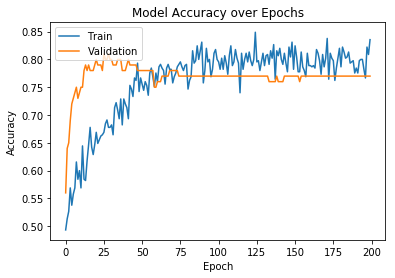

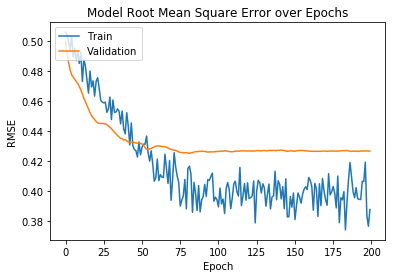

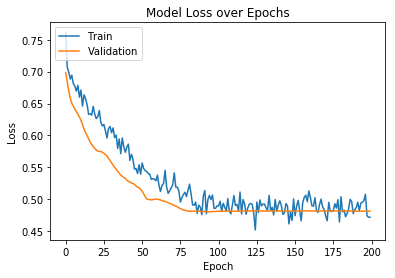

In [36]:
model_builder.print_model_metrics(fitted_model_lstm, acc_key)


In [44]:
from keras.layers import LSTM
def Simple_LSTM(look_back, chans, nb_classes):
    model = Sequential()
    model.add(LSTM(20, input_shape=(look_back, chans)))
    
    model.add(Dense(2))
    return model
simple_LSTM = Simple_LSTM(time_window, chans, 2)
#simple_LSTM.compile(loss='mean_squared_error', optimizer='adam')
simple_lstm_checkpoint = '/tmp/LSTM_checkpoint.h5'

fitted_simple_lstm = model_builder.construct_and_run_model(data, simple_LSTM, optimizer='adam',
                                                           checkpoint_file_name=simple_lstm_checkpoint, epochs=50, 
                                                           batch_size=1,
                                                           loss_type='mean_squared_error'
                                                          )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 20)                2560      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 42        
Total params: 2,602
Trainable params: 2,602
Non-trainable params: 0
_________________________________________________________________
Train on 450 samples, validate on 100 samples
Epoch 1/50


KeyboardInterrupt: 

In [28]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 15 19:12:24 2018

@author: mahparsa
"""
# you can find a sourse code here https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/
import numpy as np, cmath, scipy as sp
import scipy.io
import sklearn
import pandas as pd 
import matplotlib.pyplot as plt
import pandas
import math
from matplotlib.pyplot import *
from matplotlib import pyplot
#import basic functions from numpy that we'll need
from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle, real, imag, zeros, ceil, floor, absolute, linspace  
from numpy.fft import fft, ifft
from scipy import signal as sig
from scipy.signal import hilbert
#from matplotlib.pyplot import *
from pandas import DataFrame
from pandas import read_csv
from pandas import datetime
from pandas import Series
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#to load a data set that has been saved as .mat we use scipy.io.loadmat
data = scipy.io.loadmat('sampleEEGdata')
#type() to undersyand the type of a variable
print( "the type of data is:.... ", type(data))

EEGdata = data["EEG"][0,0]["data"]
print( "the type of EEGdata  is:.... ", type(EEGdata ))
print( "the shape of EEGdata  is:.... ", np.shape(EEGdata))

#Out[81]: (64, 640, 99)
#we are choosing cahnnel 12 for 12 subjects


dataE=EEGdata[1,:,12]
    
np.random.seed(4)


train_size = int(len(dataE) * 0.6)
test_size = len(dataE) - train_size
train, test = dataE[0:train_size], dataE[train_size:len(dataE)]
print(train)
print(train.shape)
print(len(train), len(test))
# We need to do some explorations with the data
plot(dataE)


from sklearn.preprocessing import MinMaxScaler
# normalize the dataset
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataE = scaler.fit_transform(dataE)
#plot(dataE)
# convert an array of values into a dataset matrix
#----------------------------------------to make a time series of dataE

#create-dataset creats a time series from a NumPy array

#the look_back shows the the number of previous time steps to use as input variables to predict the next time period 
#in this case defaulted to 1.


def create_dataset(dataE, look_back):
	dataX, dataY = [], []
	for i in range(len(dataE)-look_back-1):
		a = dataE[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataE[i + look_back])
	return np.array(dataX), np.array(dataY)

look_back = 4
#to define the optimal values of look-back
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX)
print(trainX.shape)

#The input vector of the LSTM network must be in the form of: [samples, time steps, features].
#Using reshape, we define it 
#number of samples=trainX.shape[0], number of time steps 
#Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
print(trainX[1])
#array([[12.475137 , 10.774388 , -4.1156535,  2.4252448]], dtype=float32)
print(dataE[1:4])
#array([12.475137 , 10.774388 , -4.1156535], dtype=float32)
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#to design and fit our LSTM network for this problem.

# visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.


model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
#the number of epochs have been choosen 10 to decrease the computaional complexity. 
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
#def RMSE(predicted, actual):
#    mse = (predicted - actual)**2
#    rmse = np.sqrt(mse.sum()/mse.count())
#    return rmse

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

plt.figure()
plt.plot(testY)
pyplot.plot(testPredict, color='red')

plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')
plt.title('EEG Prediction with a Vanila LSTM')
plt.grid(True)
plt.legend(('real values', 'predicted values'),  loc='upper right')
plt.show()

Using TensorFlow backend.


FileNotFoundError: [Errno 2] No such file or directory: 'sampleEEGdata.mat'

In [37]:
!pip freeze

absl-py==0.9.0
affine==2.3.0
aiohttp==3.6.2
alabaster==0.7.12
albumentations==0.4.3
alembic==1.4.1
allennlp==0.9.0
altair==4.0.1
anaconda-client==1.7.2
anaconda-navigator==1.9.12
anaconda-project==0.8.3
annoy==1.16.3
appdirs==1.4.3
arrow==0.15.5
arviz==0.7.0
asn1crypto==1.3.0
astor==0.8.1
astroid==2.3.3
astropy==3.2.3
async-timeout==3.0.1
atomicwrites==1.3.0
attr==0.3.1
attrs==19.3.0
audioread==2.1.8
aws-requests-auth==0.4.2
Babel==2.8.0
backcall==0.1.0
backports.functools-lru-cache==1.6.1
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
Baker==1.3
basemap==1.2.0
bayesian-optimization==1.1.0
bayespy==0.5.19
bcolz==1.2.1
beautifulsoup4==4.8.2
biopython==1.76
bitarray==1.2.1
bkcharts==0.2
bleach==3.1.0
blis==0.4.1
bokeh==1.4.0
Boruta==0.3
boto==2.49.0
boto3==1.12.13
botocore==1.15.13
Bottleneck==1.3.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
bqplot==0.12.4


In [38]:
from platform import python_version

print(python_version())

3.6.6
